In [1]:
import os
import json
import numpy as np
import pandas as pd

from src.data_loader import Shifted_Data_Loader
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.nonparametric.smoothers_lowess import lowess

Using TensorFlow backend.


See Notebook '05-Corrupted-labels' for details on training

In [2]:
np.random.seed(7)

In [3]:
corruption_fractions = np.round(np.linspace(0,1,11),decimals=1)
# idxs_corr = [np.random.choice(np.arange(60000),int(frac*60000),replace=False) for frac in corruption_fractions]
# y_tr = DL.y_train.copy()

In [4]:
y_tr_idxs = [np.load('../data/fashion_mnist_corrupted_labels/corrupted_idxs_{}.npy'.format(str(pct))) for pct in corruption_fractions[1:]]
y_tr_corr = [np.load('../data/fashion_mnist_corrupted_labels/y_train_{}.npy'.format(str(pct))) for pct in corruption_fractions[1:]]
# y_corrupted_oh = to_categorical(y_tr_corr,num_classes=10)

In [5]:
def lowess_smooth(dat,time):
    filtered = lowess(dat, time, is_sorted=True,frac=0.01,it=1)
    return filtered

def sma(y,win_size):
    weights = np.repeat(1.0, win_size) / win_size
    yMA = np.convolve(y, weights, 'same')
    return yMA

def load_config(run_dir,filename='config.json'):
    path = os.path.join(run_dir,filename)
    if os.path.exists(path):
        with open(path,'r') as config_json:
            conf = json.load(config_json)
        return conf

def load_model_spec(run_dir,filename='model.json'):
    path = os.path.join(run_dir,filename)

    if os.path.exists(path):
        with open(path,'r') as model_json:
            mod_spec = json.load(model_json)
            
        return mod_spec

def load_train_history(run_dir,conf,filename='train_history.parquet'):
    path = os.path.join(run_dir,filename)
    dirname,fname = os.path.split(path)
#     lab_corruption = np.round(float(dirname.split('/')[-1].split('_')[-1]),decimals=1)
#     arch = dirname.split('/')[-2]
    if conf is None:
        return None
    elif conf['recon'] == 0:
        arch = 'no_recon'
    else:
        arch = 'recon'

    if os.path.exists(path):
        hist = pd.read_parquet(path)
        hist['architecture'] = arch
        hist['label_corruption'] = conf['label_corruption']
        hist['ecc_max'] = conf['ecc_max']
        hist['epoch'] = list(hist.index.values*3)
#         hist['val_loss'] = sma(hist['val_loss'].values,win_size=3)
#         hist['loss'] = sma(hist['loss'].values,win_size=3)
        hist['val_dL'] = np.gradient(hist['val_loss'])
        hist['test_err'] = 1-hist['val_class_acc']
        hist['train_err'] = 1-hist['class_acc']
        hist['recon_gen_err'] = hist.G_loss - hist.val_G_loss
        hist['gen_err'] = hist.loss - hist.val_loss
        hist['class_gen_err'] = hist.class_loss - hist.val_class_loss
        hist['class_gen_acc'] = hist.class_acc - hist.val_class_acc

        return hist

def load_performance(run_dir, conf, th=None, filename='performance.json'):
    path = os.path.join(run_dir,filename)
#     dirname,fname = os.path.split(path)
#     arch = dirname.split('/')[-2]
    if conf is None:
        return None
    elif conf['recon'] == 0:
        arch = 'no_recon'
    else:
        arch = 'recon'

    if os.path.exists(path):
        with open(path, 'rb') as json:
            
            perf = pd.read_json(json)
            perf['architecture'] = arch

            perf['test_err'] = 1-perf['test_acc']
        if th is not None:
            perf['test_acc_max'] = th['val_class_acc'].values.max()
            perf['tt_overfit'] = np.argmax(th['val_class_acc'].values)
            tt_mem_bin_vec = (th['class_acc'].values<= 1-conf['label_corruption']).astype(int)
            perf['tt_memorization'] = tt_mem_bin_vec.sum()*3
            perf['test_err_min'] = 1-perf['test_acc_max']
            perf['test_acc_auc'] = np.trapz(th['val_class_acc'])
            perf['test_loss_auc'] = np.trapz(th['val_class_loss'],th['epoch'])
            perf['train_loss_auc'] = np.trapz(th['class_loss'])
        return perf

In [6]:
exp_root = '/home/elijahc/projects/vae/models/2019-05-03'
runs = []
for branches in os.listdir(exp_root):
    for leaf in os.listdir(os.path.join(exp_root,branches)):
        runs.append(os.path.join(exp_root,branches,leaf))
# recon_ecc_root = os.path.join(exp_root,'recon_and_ecc')
# recon_runs = [os.path.join(recon_root,d) for d in os.listdir(recon_root)]
# recon_runs.extend([os.path.join(recon_ecc_root,d) for d in os.listdir(recon_ecc_root)])
runs = list(filter(lambda x: 'ipynb_checkpoints' not in x,runs))
configs = [load_config(rd) for rd in runs]
train_historys = [load_train_history(rd,conf) for rd,conf in zip(runs,configs)]
perf = [load_performance(rd,conf,th) for rd,conf,th in zip(runs,configs,train_historys)]
model_specs = [load_model_spec(rd) for rd in runs]

# no_recon_root = os.path.join(exp_root,'no-recon')
# no_recon_runs = [os.path.join(no_recon_root,d) for d in os.listdir(no_recon_root)]
# no_recon_configs = 
# no_recon_train_historys = [load_train_history(rd,'no_recon') for rd in no_recon_runs]
# no_recon_perf = [load_performance(rd,'no_recon') for rd in no_recon_runs]

In [7]:
configs_df = pd.DataFrame.from_records(configs)

In [8]:
len(model_specs)

6

In [9]:
# len(configs_df.model_name)

In [10]:
configs_df.to_csv('../models/experiments/label_corruption_large_z/all_configs.csv')

In [11]:
hist_df = pd.concat(train_historys)

In [12]:
# from sklearn.preprocessing import MinMaxScaler
# norm_hist = []
# for ecc,arch in zip([0.0,0.8,0.0,0.8],['recon','recon','no_recon','no_recon']):
#     df = hist_df.query(' & '.join(['ecc_max == {}'.format(ecc),'architecture == "{}"'.format(arch)]))
#     for metric in ['class_loss','class_acc']:
#         norm_metric = np.squeeze(MinMaxScaler().fit_transform(df[metric].values.reshape(-1,1)))
#         df['val_norm_{}'.format(metric)] = norm_metric
        
#         val_norm_metric = np.squeeze(MinMaxScaler().fit_transform(df['val_{}'.format(metric)].values.reshape(-1,1)))
#         df['val_norm_{}'.format(metric)] = val_norm_metric

#     norm_hist.append(df)

In [13]:
# hist_df = pd.concat(norm_hist)

In [14]:
hist_df.to_csv('../models/experiments/label_corruption_large_z/train_history_all.csv')

In [15]:
perf_df = pd.concat(perf)

In [16]:
perf_df.to_csv('../models/experiments/label_corruption_large_z/performance_summary_all.csv')

In [17]:
hist_df.head()

,G_loss,G_mse,class_acc,class_loss,loss,val_G_loss,val_G_mse,val_class_acc,val_class_loss,val_loss,...,label_corruption,ecc_max,epoch,val_dL,test_err,train_err,recon_gen_err,gen_err,class_gen_err,class_gen_acc
0,1303.697032,1303.697032,0.189683,2.205989,165.095314,1236.209086,1236.209086,0.295667,1.962508,116.069585,...,0.4,0.8,0,-4.495427,0.704333,0.810317,67.487946,49.025730,0.243481,-0.105983
1,1306.406661,1306.406661,0.227939,2.147111,117.108117,1294.839172,1294.839172,0.341333,1.880019,111.574157,...,0.4,0.8,3,-3.869826,0.658667,0.772061,11.567489,5.533959,0.267092,-0.113394
2,1304.274244,1304.274244,0.239444,2.130212,113.632562,1325.363242,1325.363242,0.333000,1.873606,108.329932,...,0.4,0.8,6,-3.419994,0.667000,0.760556,-21.088998,5.302630,0.256606,-0.093556
3,1304.325432,1304.325432,0.247556,2.121702,110.460088,1311.584017,1311.584017,0.369000,1.830630,104.734170,...,0.4,0.8,9,-3.272129,0.631000,0.752444,-7.258585,5.725919,0.291072,-0.121444
4,1301.056757,1301.056757,0.252472,2.115567,107.504347,1330.691291,1330.691291,0.350667,1.817913,101.785674,...,0.4,0.8,12,-2.558117,0.649333,0.747528,-29.634534,5.718673,0.297654,-0.098194


In [18]:
# vcloss_pv = hist_df.pivot_table(values=['val_class_loss'],index='epoch',columns=['label_corruption']).dropna()
# closs_pv = hist_df.pivot_table(values=['class_loss'],index='epoch',columns=['label_corruption']).dropna()
# closs_pv['auc'] = [np.trapz(row.values,[0.0,0.2,0.4,0.6,0.8]) for i,row in closs_pv.iterrows()]

In [19]:
# sns.scatterplot(data=hist_df[['val_class_acc','class_acc']].query('architecture = "recon"'))

In [20]:
def fmin_search(df,metric='val_class_loss',group_cols=['ecc_max','architecture','label_corruption']):
    fmins = df.groupby(group_cols).apply(lambda d:d[metric].idxmin())
    return fmins

In [21]:
fmin_search(hist_df).index.names

FrozenList(['ecc_max', 'architecture', 'label_corruption'])

In [22]:
def train_plot(metric,filts={'ecc_max':0.0,'architecture':'no_recon'},pop_out_legend=True,legend='full'):
    pd_query = []
    for k in filts.keys():
        if isinstance(filts[k],str):
            qs = "{} == '{}'".format(k,filts[k])
        else:
            qs = "{} == {}".format(k,filts[k])
        
        pd_query.append(qs)
        
    if legend is not None and pop_out_legend:
        fig_size = (8,5)
    else:
        fig_size = (5,5)
    
    fig,ax = plt.subplots(1,1,figsize=fig_size)
    
    sns.lineplot(x='epoch',y='class_acc',hue='label_corruption',data=hist_df.query(' & '.join(pd_query)),legend=legend,ax=ax)
    
    if legend is not None and pop_out_legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    plt.tight_layout()
    return fig

In [23]:
def train_plot(metric,
               filts={'ecc_max':0.0,'architecture':'no_recon'},
               pop_out_legend=True,legend='full',acc_hlines=True,
               sp_kw=None,):
    pd_query = []
    for k in filts.keys():
        if isinstance(filts[k],str):
            qs = "{} == '{}'".format(k,filts[k])
        else:
            qs = "{} == {}".format(k,filts[k])
        
        pd_query.append(qs)
        
    if legend is not None and pop_out_legend:
        fig_size = (8,5*2)
    else:
        fig_size = (5,5*2)
    
    fig,axs = plt.subplots(2,1,figsize=fig_size,sharex=True,
                           subplot_kw=sp_kw,
                          )
    
    es_range = fmin_search(hist_df).loc[(filts['ecc_max'],filts['architecture'])]
    for ax,v,leg in zip(axs,['{}','val_{}'],[legend,None]):
        sns.lineplot(x='epoch',y=v.format(metric),hue='label_corruption',
                     data=hist_df.query(' & '.join(pd_query)),
                     legend=leg,ax=ax)
        if acc_hlines:
            for c,chance in zip(sns.cubehelix_palette(6,reverse=True,start=1),[0.2,0.4,0.8]): 
                ax.axhline(y=chance,ls='dashed',color=c,xmin=0.0,xmax=0.5)
        
#         ax.axvline(x=es_range.values.min()*3,color='k')
#         ax.axvline(x=es_range.values.max()*3,color='k')

    
    ax = axs[0]
    if legend is not None and pop_out_legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    
    
    plt.tight_layout()
    return fig

In [24]:
def recon_ecc_grid(metric='class_acc',sharey=True,sharex=True,subplot_kw=None,leg='full'):
    archs = ['no_recon','recon']
    filts = [hist_df.architecture == a for a in archs]

    fig,axs = plt.subplots(2,2,figsize=(10,10),
                           sharey=sharey,
                           sharex=sharex,
                           subplot_kw=subplot_kw,
                          )
    for filt,i in zip(filts,np.arange(2)):
        if i == 0:
            leg = leg
        else:
            leg = None
        if len(hist_df[filt]) > 0:
            sns.lineplot(x='epoch',y=metric,hue='label_corruption',data=hist_df[filt].query('ecc_max == 0.0'),ax=axs[i,0],legend=None)
#             axs[i,0].set_yscale(yscale)
            axs[i,0].set_title('ecc: 0.0')

            sns.lineplot(x='epoch',y=metric,hue='label_corruption',data=hist_df[filt].query('ecc_max == 0.8'),ax=axs[i,1],legend=leg)
            axs[i,1].set_title('ecc: 0.8')
    #         plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    
    return fig

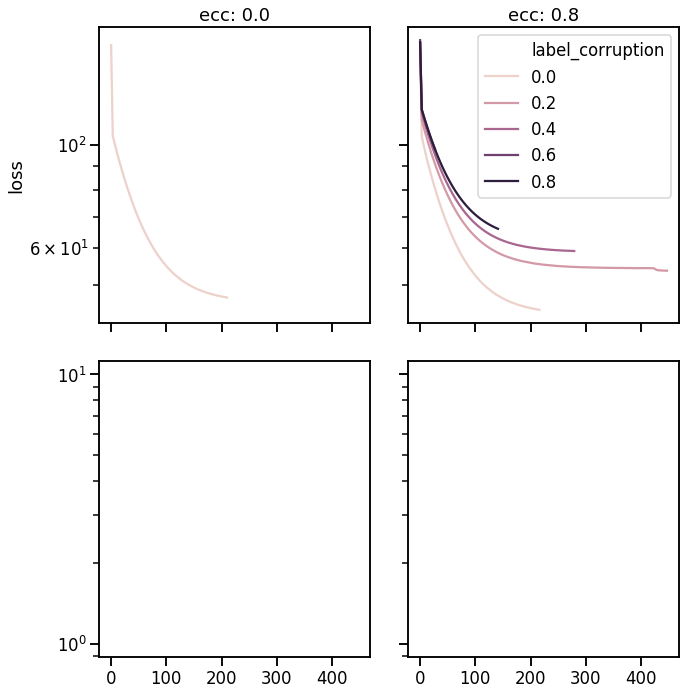

In [25]:
sns.set_context('talk')
fig = recon_ecc_grid(metric='loss',sharey='row',
                    subplot_kw={
                         'yscale':'log',
#                          'xscale':'log'
                    })

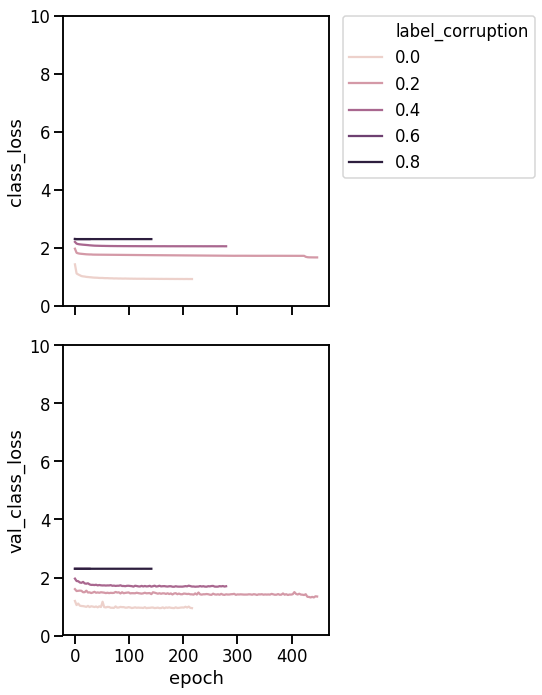

In [39]:
fig = train_plot(metric='class_loss',
                 sp_kw={
#                      'yscale':'log',
                     'ylim':(0.01,10)
                 },
                 filts={
                     'ecc_max':0.8,
                     'architecture':'no_recon'
                 },acc_hlines=False)

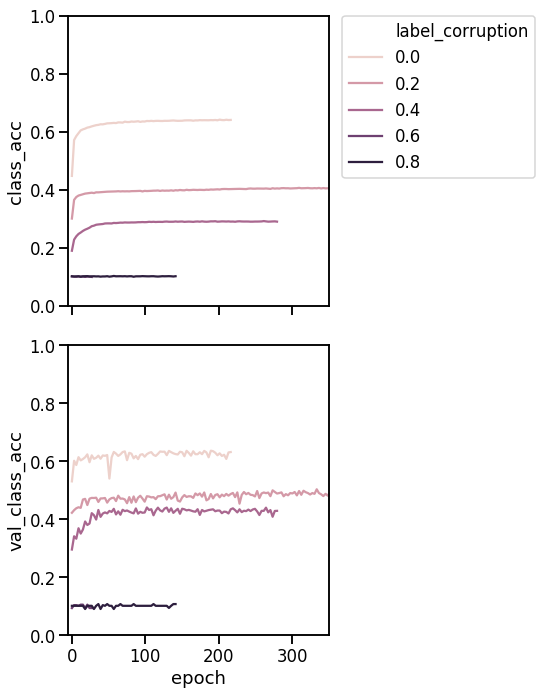

In [42]:
fig = train_plot(metric='class_acc',
                 sp_kw={
                     'ylim':(0,1),
                     'xlim':(-5,350)
                 },
                 filts={
                     'ecc_max':0.8,
                     'architecture':'no_recon'
                 },acc_hlines=False)

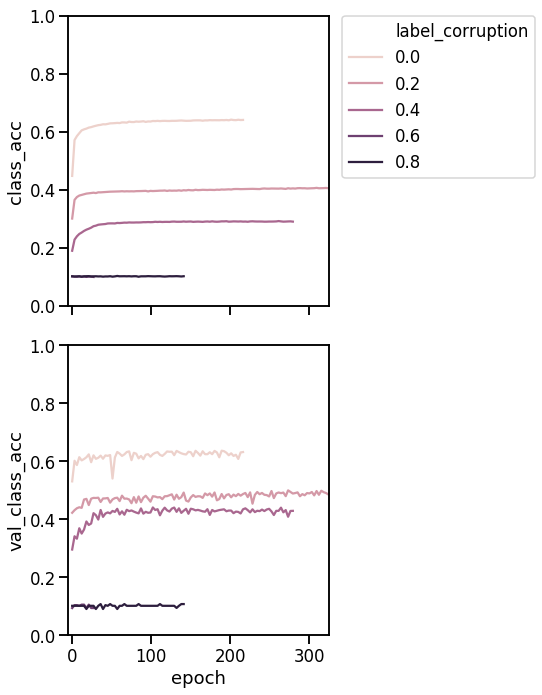

In [28]:
fig = train_plot(metric='class_acc',
                 sp_kw={
#                      'yscale':'log',
                     'ylim':(0,1),
                     'xlim':(-5,325)

                 },
                 filts={
                     'ecc_max':0.8,
                     'architecture':'no_recon'
                 },acc_hlines=False)

In [29]:
es = fmin_search(hist_df)

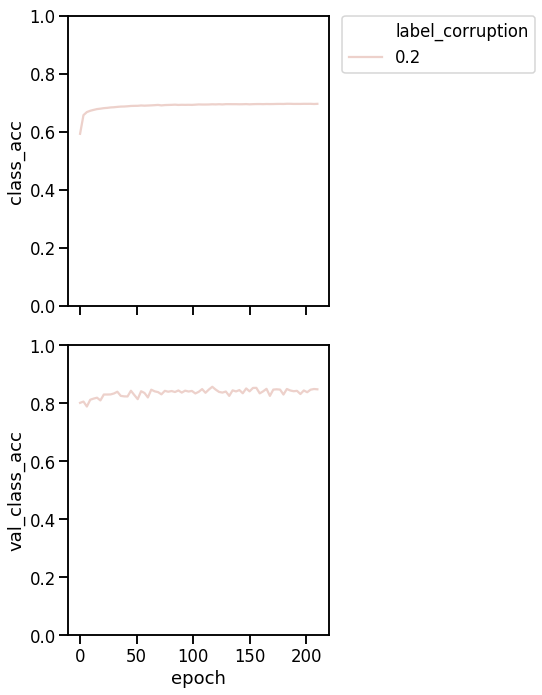

In [30]:
fig = train_plot(metric='class_acc',
                 sp_kw={
#                      'yscale':'log',
                     'ylim':(0,1),

                 },
                 filts={
                     'ecc_max':0.0,
                     'architecture':'no_recon'
                 },acc_hlines=False)

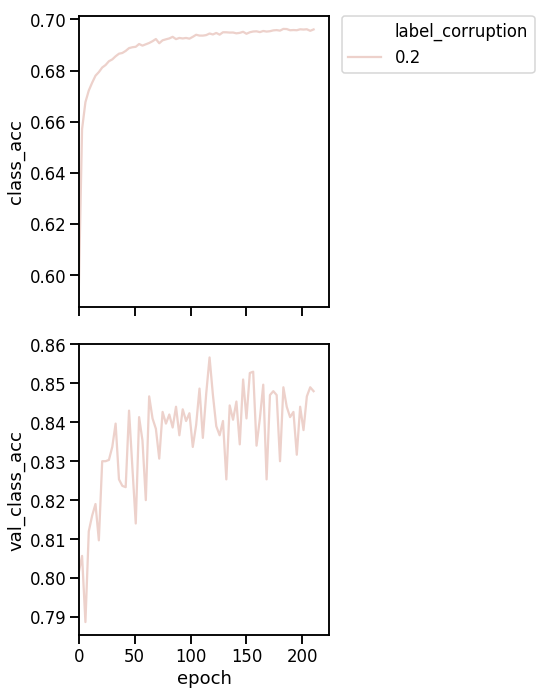

In [31]:
filts={
    'architecture':'no_recon',
    'ecc_max':0.0,
}
max_es = fmin_search(hist_df).loc[(filts['ecc_max'],filts['architecture'])].values.max()*3
fig = train_plot(metric='class_acc',acc_hlines=False,
                 filts=filts,
                 sp_kw = {
                     'xlim':(0,int(max_es*1.1)),
                 },
                )

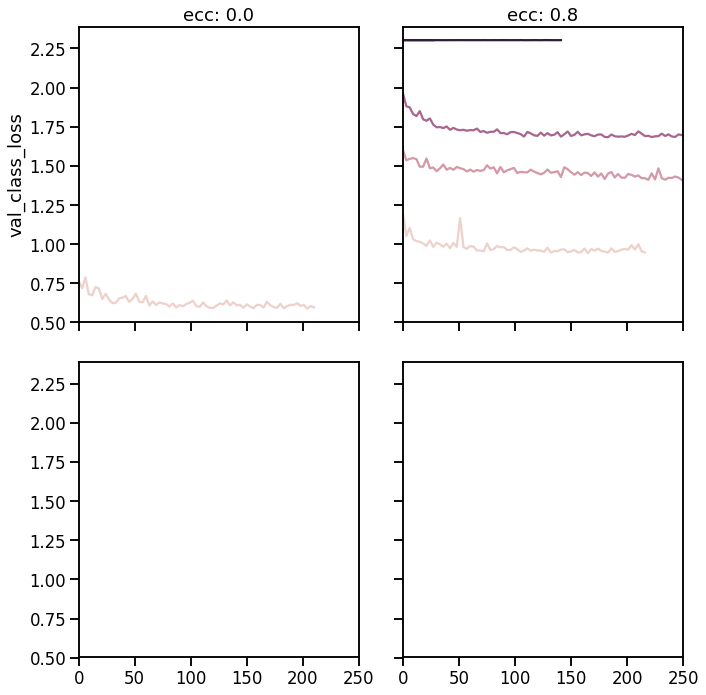

In [32]:
sns.set_context('talk')
fig = recon_ecc_grid(metric='val_class_loss',sharey=True,leg=None,
                    subplot_kw={
#                          'yscale':'log',
#                          'xscale':'log',
#                         'ylim':(0.1,6.5),
                        'xlim':(0,250),
                    })

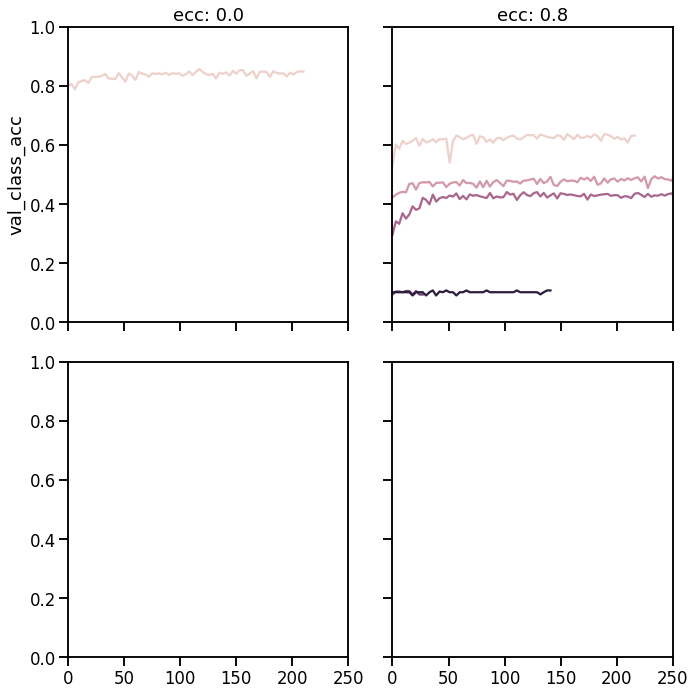

In [33]:
sns.set_context('talk')
fig = recon_ecc_grid(metric='val_class_acc',
                     subplot_kw={
#                          'xscale':'log',
                         'xlim':(0,250),
                         'ylim':(0,1),
                     },sharey='row',leg=None)

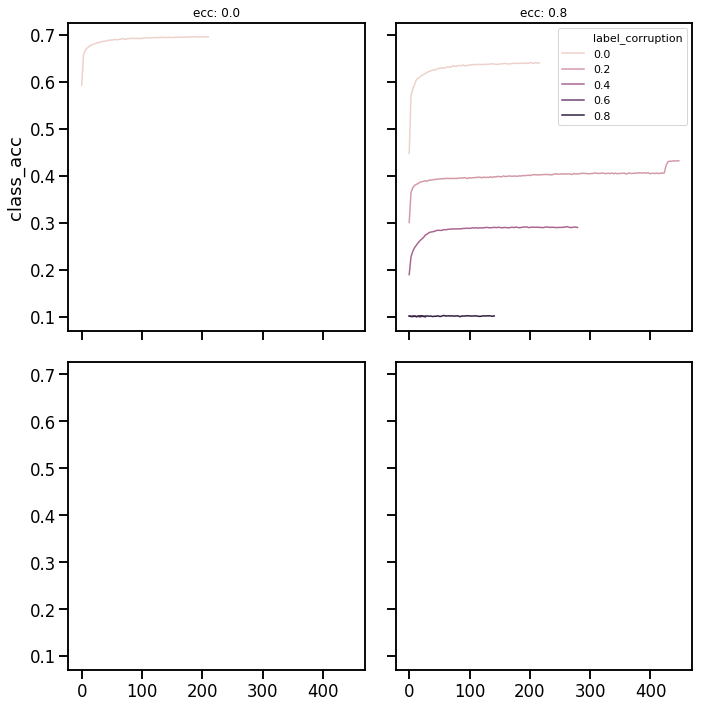

In [34]:
archs = ['no_recon','recon']
filts = [hist_df.architecture == a for a in archs]

fig,axs = plt.subplots(2,2,figsize=(10,10),
                       sharey=True,
                       sharex=True,
                      )
sns.set_context('notebook')
for filt,i in zip(filts,np.arange(2)):
    if i == 0:
        leg = 'full'
    else:
        leg = None
    if len(hist_df[filt]) > 0:
        sns.lineplot(x='epoch',y='class_acc',hue='label_corruption',data=hist_df[filt].query('ecc_max == 0.0'),ax=axs[i,0],legend=None)
        axs[i,0].set_title('ecc: 0.0')
        
        sns.lineplot(x='epoch',y='class_acc',hue='label_corruption',data=hist_df[filt].query('ecc_max == 0.8'),ax=axs[i,1],legend=leg)
        axs[i,1].set_title('ecc: 0.8')
#         plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
fig.savefig('../figures/label_corruption_sweeps/train_acc.png',dpi=150)

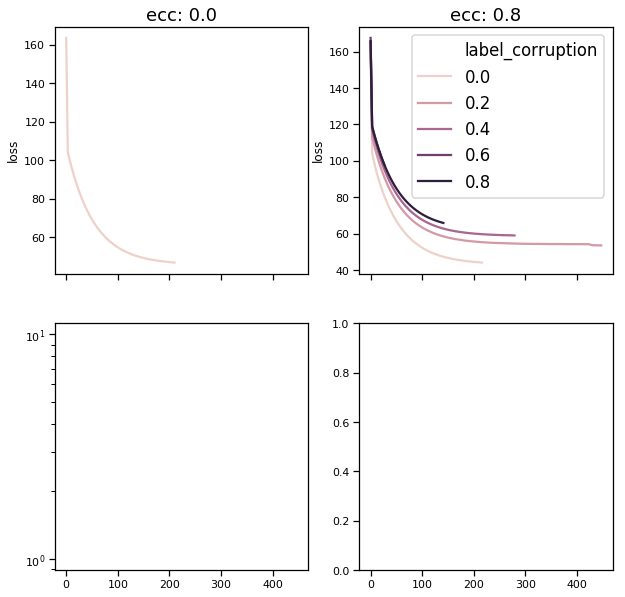

In [35]:
archs = ['no_recon','recon']
filts = [hist_df.architecture == a for a in archs]

fig,axs = plt.subplots(2,2,figsize=(10,10),
#                        sharey=True,
                       sharex=True,
                      )
sns.set_context('talk')
for filt,i in zip(filts,np.arange(2)):
    if i == 0:
        leg = 'full'
    else:
        leg = None
    if len(hist_df[filt]) > 0:
        axs[1,i].set_yscale('log')
        sns.lineplot(x='epoch',y='loss',hue='label_corruption',data=hist_df[filt].query('ecc_max == 0.0'),ax=axs[i,0],legend=None)
        axs[i,0].set_title('ecc: 0.0')
        
        sns.lineplot(x='epoch',y='loss',hue='label_corruption',data=hist_df[filt].query('ecc_max == 0.8'),ax=axs[i,1],legend=leg)
        axs[i,1].set_title('ecc: 0.8')

In [36]:
def corruption_plot(x,y,hue,hue_order=None,style=None,data=None,legend=None,palette=None,ax=None):
    g = sns.lineplot(x=x,y=y,hue=hue,hue_order=hue_order,style=style,
                 data=data,legend=legend,palette=palette,ax=ax)
    if legend is not None:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    return g

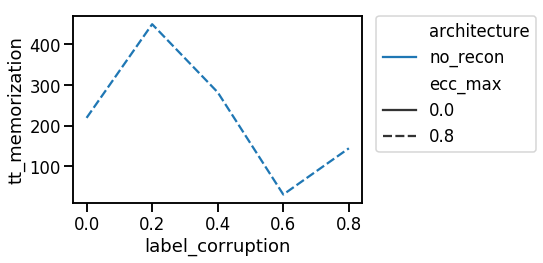

In [37]:
sns.set_context('talk')
fig,ax = plt.subplots(1,1,figsize=(8,4))
corruption_plot(x='label_corruption',y='tt_memorization',hue='architecture',style='ecc_max',data=perf_df,legend='full',ax=ax)
plt.tight_layout()
fig.savefig('../figures/label_corruption_sweeps/tt_memorization.png',dpi=150)

In [38]:
sns.set_context('talk')
corruption_plot(x='label_corruption',y='tt_memorization',hue='architecture',style='ecc_max',data=perf_df,legend='full',palette=sns.cubehelix_palette(2,start=5))
# fig,axs = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)


# axs[0].set_title('no_recon')

# g = sns.lineplot(x='label_corruption',y='tt_memorization',hue='ecc_max',hue_order=[0,0.8],
#                  data=perf_df.query('architecture == "recon"'),legend='full',ax=axs[1],palette=sns.cubehelix_palette(2,start=5))
# axs[1].set_title('recon')
# plt.ylim(0,1.1)
# plt.xlim(0,1.1)

ValueError: The palette list has the wrong number of colors.

In [ ]:
sns.set_context('talk')
fig = recon_ecc_grid(metric='val_class_loss',
                     subplot_kw={
#                          'xscale':'log',
#                          'xlim':(1,500),
                     },sharey=True)

In [ ]:
sns.set_context('talk')
fig,ax = plt.subplots(1,1,figsize=(8,4))
corruption_plot(x='label_corruption',y='test_loss_auc',hue='architecture',style='ecc_max',data=perf_df,legend='full')
plt.tight_layout()
fig.savefig('../figures/label_corruption_sweeps/test_loss_auc.png',dpi=150)

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(10,5),sharey=True,sharex=True)
g = sns.barplot(x='label_corruption',y='test_loss_auc',hue='architecture',hue_order=['recon','no_recon'],data=perf_df.query('ecc_max == 0.0'),ax=axs[0])
g = sns.barplot(x='label_corruption',y='test_loss_auc',hue='architecture',hue_order=['recon','no_recon'],data=perf_df.query('ecc_max == 0.8'),ax=axs[1])
# g.set(legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axs[0].set_xticklabels([0.2,0.4,0.6,0.8,0.9,1.0])
axs[1].set_xticklabels([0.2,0.4,0.6,0.8,0.9,1.0])
axs[1].set_ylabel('')
plt.tight_layout()
fig.savefig('../figures/label_corruption_sweeps/test_loss_auc_barplot.png',dpi=150)

In [ ]:

fig,axs = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
g = sns.lineplot(x='label_corruption',y='test_loss_auc',hue='ecc_max',hue_order=[0,0.8],
                 data=perf_df.query('architecture == "no_recon"'),legend='full',ax=axs[0],palette=sns.cubehelix_palette(2,start=5))
g = sns.lineplot(x='label_corruption',y='test_loss_auc',hue='ecc_max',hue_order=[0,0.8],
                 data=perf_df.query('architecture == "recon"'),legend='full',ax=axs[1],palette=sns.cubehelix_palette(2,start=5))

# plt.ylim(0,1.1)
# plt.xlim(0,1.1)

In [ ]:
# sns.set_context('talk')

# fig,axs = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
# g = sns.lineplot(x='label_corruption',y='test_loss_auc',hue='architecture',hue_order=['no_recon','recon'], data=perf_df.query('ecc_max == "0.0"'),legend='full',ax=axs[0])
# g = sns.lineplot(x='label_corruption',y='test_loss_auc',hue='architecture',hue_order=['no_recon','recon'],data=perf_df.query('ecc_max == "0.8"'),legend='full',ax=axs[1])

# # plt.ylim(0,1.1)
# # plt.xlim(0,1.1)

In [ ]:
sns.cubehelix_palette(6)

In [ ]:
archs = ['no_recon','recon']
filts = [hist_df.architecture == a for a in archs]

fig,axs = plt.subplots(2,2,figsize=(10,10),
                       sharey=True,
                       sharex=True,
                      )
for filt,i in zip(filts,np.arange(2)):
    if i == 1:
        leg = 'full'
    else:
        leg = None
    if len(hist_df[filt]) > 0:
        sns.lineplot(x='epoch',y='val_class_acc',hue='label_corruption',data=hist_df[filt].query('ecc_max == 0.0'),ax=axs[i,0],legend=None)
#         axs[i,0].set_title('no_recon')
        
        sns.lineplot(x='epoch',y='val_class_acc',hue='label_corruption',data=hist_df[filt].query('ecc_max == 0.8'),ax=axs[i,1],legend=None)
#         axs[i,1].set_title('recon')
        for c,chance in zip(sns.cubehelix_palette(6,reverse=True,start=1),[0.1,0.2,0.4,0.6,0.8]): 
            axs[i,0].axhline(y=chance,ls='dashed',color=c,xmin=0.25)
            axs[i,1].axhline(y=chance,ls='dashed',color=c,xmin=0.25)
            
fig.savefig('../figures/label_corruption_sweeps/val_class_acc.png',dpi=150)